In [33]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils import resample
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style('darkgrid')

In [2]:
# Load up the data.
#ga stands for gender/age
ga_train = pd.read_csv('gender_age_train.csv')
ga_test = pd.read_csv('gender_age_test.csv' )
# 
phone_brands = pd.read_csv('phone_brand_device_model.csv')
# Get rid of duplicate device ids in phone
phone_brands = phone_brands.drop_duplicates('device_id',keep='first')
# Location data
events = pd.read_csv('events.csv', usecols = ['event_id', 'device_id'])
app_events = pd.read_csv('app_events.csv', usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
app_labels = pd.read_csv('app_labels.csv')
label_cats = pd.read_csv('label_categories.csv', index_col='label_id',squeeze=True)

# Exploratory Data Analysis

In [3]:
print('Shape of ga_train data set:')
print(ga_train.shape)
ga_train.head()

Shape of ga_train data set:
(74645, 4)


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


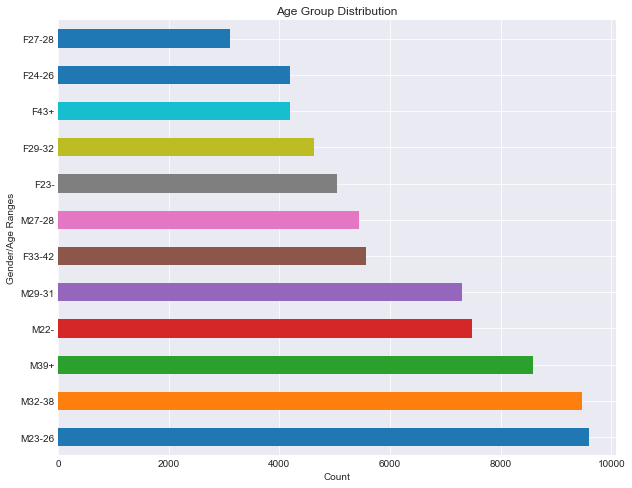

In [4]:
# Distribution of age based users.
fig,ax = plt.subplots(figsize=(10,8))
ga_train.group.value_counts().plot(kind='barh')
plt.title('Age Group Distribution')
plt.ylabel('Gender/Age Ranges')
plt.xlabel('Count');

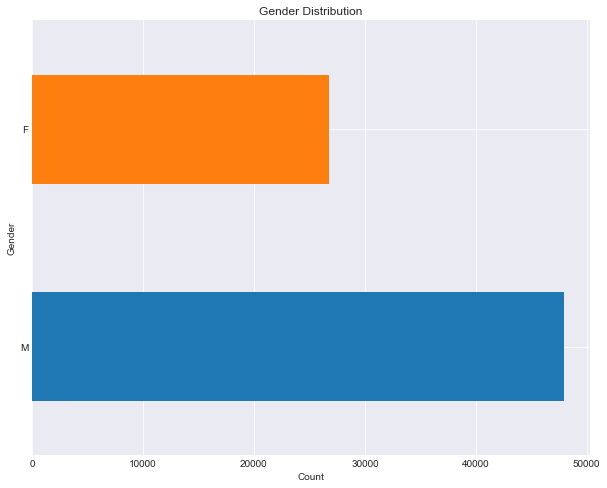

In [5]:
# Gender Distribution
fig,ax = plt.subplots(figsize=(10,8))
ga_train.gender.value_counts().plot(kind='barh')
plt.title('Gender Distribution')
plt.xlabel('Count')
plt.ylabel('Gender');

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


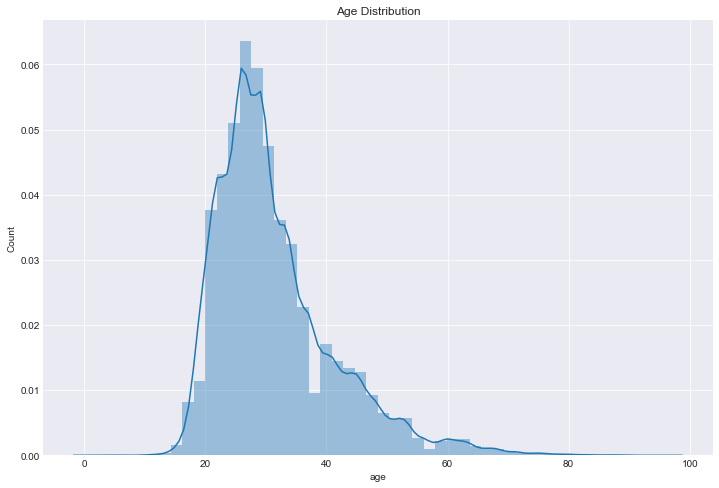

In [6]:
# Age Distribution
fig,ax = plt.subplots(figsize=(12,8))
plt.title('Age Distribution')
plt.xlabel('Ages')
plt.ylabel('Count')
sns.distplot(ga_train.age);

In [7]:
print('Shape of phone brands data set:')
print(phone_brands.shape)
phone_brands.head()

Shape of phone brands data set:
(186716, 3)


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [8]:
print('Number of unique brands:')
print(phone_brands.phone_brand.nunique())

print('\nNumber of unique models:')
print(phone_brands.device_model.nunique())

Number of unique brands:
131

Number of unique models:
1599


In [9]:
# Check to see if there is over representation of any one brand. 
device_count = phone_brands.groupby(['device_model'])['phone_brand'].apply(pd.Series.nunique)
device_count.value_counts()

1    1545
2      43
3       8
4       3
Name: phone_brand, dtype: int64

In [10]:
# App events overlook
print('shape of events data set:')
print(app_events.shape)
app_events.head(25)

shape of events data set:
(32473067, 3)


,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True
5,2,4775896950989639373,True
6,2,-8022267440849930066,False
7,2,9112463267739110219,False
8,2,-3725672010020973973,False
9,2,7167114343576723123,True


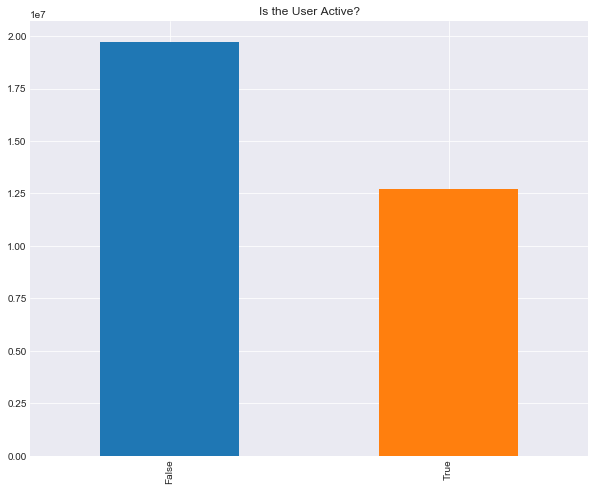

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plt.title('Is the User Active?')
app_events['is_active'].value_counts().plot(kind='bar');

In [12]:
print('Shape of events:')
print(events.shape)
events.head()

Shape of events:
(3252950, 2)


,event_id,device_id
0,1,29182687948017175
1,2,-6401643145415154744
2,3,-4833982096941402721
3,4,-6815121365017318426
4,5,-5373797595892518570


# Data Exploration (No Graphs)

In [3]:
# Check numerical value of age groups
ga_train.group.value_counts()

M23-26    9605
M32-38    9476
M39+      8581
M22-      7488
M29-31    7309
F33-42    5561
M27-28    5445
F23-      5050
F29-32    4628
F43+      4194
F24-26    4190
F27-28    3118
Name: group, dtype: int64

In [4]:
# Re-import app_events for the binary output of is_active
app_events2 = pd.read_csv('app_events.csv', usecols=['event_id','app_id','is_active'])

In [5]:
device_apps = (
    app_events2
    
     # Merge on event_id
    .merge(events, how = 'left', left_on = 'event_id', right_on = 'event_id')
    
     # event_id itself is not interesting
    .drop('event_id', axis = 1)
    
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates()
)

# Our data now looks like this
device_apps.head()

,app_id,is_active,device_id
0,5927333115845830913,1,-6401643145415154744
1,-5720078949152207372,0,-6401643145415154744
2,-1633887856876571208,0,-6401643145415154744
3,-653184325010919369,1,-6401643145415154744
4,8693964245073640147,1,-6401643145415154744


In [6]:
device_apps.shape

(2840343, 3)

In [7]:
# Encode the device_model and phone_brand to use as a feature.
phone_brands.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [8]:
# It seems like some brands don't have specific model names.
print('Number of distinct model names: ' + str(phone_brands.groupby(['device_model']).size().shape[0]))
print('Number of distinct brand+model names: ' + str(phone_brands.groupby(['phone_brand','device_model']).size().shape[0]))

Number of distinct model names: 1599
Number of distinct brand+model names: 1667


In [9]:
# Combine the two columns
phone_brands['brand_and_model'] = phone_brands['phone_brand'].astype(str) + phone_brands['device_model']

# Build numerical labels for our models
modelencoder = LabelEncoder().fit(phone_brands['brand_and_model'])

# Store in a new column
phone_brands['encoded_model'] = modelencoder.transform(phone_brands['brand_and_model'])

In [10]:
# Take a look to see what phone_brands look like now.
phone_brands.head(50)

,device_id,phone_brand,device_model,brand_and_model,encoded_model
0,-8890648629457979026,小米,红米,小米红米,858
1,1277779817574759137,小米,MI 2,小米MI 2,843
2,5137427614288105724,三星,Galaxy S4,三星Galaxy S4,371
3,3669464369358936369,SUGAR,时尚手机,SUGAR时尚手机,166
4,-5019277647504317457,三星,Galaxy Note 2,三星Galaxy Note 2,347
5,3238009352149731868,华为,Mate,华为Mate,671
6,-3883532755183027260,小米,MI 2S,小米MI 2S,846
7,-2972199645857147708,华为,G610S,华为G610S,648
8,-5827952925479472594,小米,MI One Plus,小米MI One Plus,852
9,-8262508968076336275,vivo,S7I,vivoS7I,214


In [11]:
# Check to see if encoding process has followed through correctly. 
phone_brands.encoded_model.nunique()

1667

# Merging Files Together

In [12]:
print(app_labels.shape)
app_labels.head()

(459943, 2)


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [13]:
print(app_events.shape)
app_events.head()

(32473067, 3)


,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True


Previously, my kernel would crash after merging the two files together without using drop dupes. My solution is to drop duplicates and thats why it is spelled 'ddupe' for drop dupe. The reason the kernel would crash shortly after the creation of the new file is due to the fact that the rows grew from 32 million to over 200 million. 

In [14]:
# Experimenting with how to handle dupes. 
# Adding labels to app_events
apps_labeled = pd.merge(app_labels,
                       app_events[['app_id', 'is_active']],
                       on='app_id').dropna().drop_duplicates()

print(apps_labeled.shape)
apps_labeled.head()

(117374, 3)


,app_id,label_id,is_active
0,7324884708820027918,251,False
6,7324884708820027918,251,True
11,7324884708820027918,691,False
17,7324884708820027918,691,True
22,7324884708820027918,751,False


In [15]:
# Merge ga_train and device_apps
ga_apps = pd.merge(ga_train,
                  device_apps[['app_id', 'is_active', 'device_id']],
                  on='device_id').dropna()
#Shape of ga_apps
print(ga_apps.shape)

# Show how the new df looks.
ga_apps.head()

(1097150, 6)


,device_id,gender,age,group,app_id,is_active
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0
4,-8260683887967679142,M,35,M32-38,877288515501232570,1


In [16]:
# Merge the previous data set with brands now. 
ga_apps_brands = pd.merge(ga_apps,
                         phone_brands[['device_id', 'encoded_model']],
                         on='device_id').dropna()
#Show me the shape
print(ga_apps_brands.shape)

#Look at how the data looks.
ga_apps_brands.head()

(1097150, 7)


,device_id,gender,age,group,app_id,is_active,encoded_model
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0,843
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0,843
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0,843
4,-8260683887967679142,M,35,M32-38,877288515501232570,1,843


In [17]:
# Putting all of the data sets together.
ga_apps_labeled_brands = pd.merge(ga_apps_brands,
                                 apps_labeled[['app_id', 'label_id']],
                                 on='app_id').dropna().drop_duplicates()
#Show me the shape
print(ga_apps_labeled_brands.shape)

#Look at how the data looks.
ga_apps_labeled_brands.head()

(7034111, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,F,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,F,22,F23-,4287147352639325907,0,226,704


In [18]:
# Convert gender into a binary output
ga_apps_labeled_brands['gender'] = ga_apps_labeled_brands['gender'].apply(lambda x: 1 if 'M' else 0 )

# Creating Dummies

In [19]:
# Convert label_id into a continuous variable
# even though it's numerical, it hasn't been standardized 
type_dummies = pd.get_dummies(ga_apps_labeled_brands['label_id'])

# Concatenate the dummies with the original data set.
ga_apps_labeled_brands = pd.concat([ga_apps_labeled_brands, type_dummies], axis=1)

print(ga_apps_labeled_brands.shape)

ga_apps_labeled_brands.head()

(7034111, 493)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,713,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,704,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,548,0,0,...,0,0,0,0,0,0,0,0,0,0
6,8761770737926125955,1,22,F23-,4287147352639325907,0,226,713,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8761770737926125955,1,22,F23-,4287147352639325907,0,226,704,0,0,...,0,0,0,0,0,0,0,0,0,0


# Addressing Class Imbalance

In [20]:
# Take a look at the distribution of the group values.
ga_apps_labeled_brands.group.value_counts()

M32-38    1185421
M39+      1107632
M23-26     817660
M29-31     810956
M27-28     530780
F33-42     517420
M22-       490009
F43+       391188
F29-32     368450
F23-       303034
F24-26     265262
F27-28     246299
Name: group, dtype: int64

In [21]:
# Upsampling and Downsampling the gender/age training set to 50000.
ga_m_youngest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M22-']
ga_m_younger = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M23-26']
ga_m_young = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M27-28']
ga_m_old = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M29-31']
ga_m_older = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M32-38']
ga_m_oldest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M39+']
ga_f_youngest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F23-']
ga_f_younger = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F24-26']
ga_f_young = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F27-28']
ga_f_old = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F29-32']
ga_f_older = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F33-42']
ga_f_oldest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F43+']

# Downsample majority class
ga_m_older_downsampled = resample(ga_m_older, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_oldest_downsampled = resample(ga_m_oldest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_younger_downsampled = resample(ga_m_younger, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_youngest_downsampled = resample(ga_m_youngest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)  
 
ga_m_old_downsampled = resample(ga_m_old, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_f_older_downsampled = resample(ga_f_older, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_m_young_downsampled = resample(ga_m_young, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_f_youngest_downsampled = resample(ga_f_youngest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_f_old_downsampled = resample(ga_f_old, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_f_oldest_downsampled = resample(ga_f_oldest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)


# Upsample minority class
ga_f_younger_upsampled = resample(ga_f_younger, 
                                 replace=True,     # sample with replacement
                                n_samples=50000)

ga_f_young_upsampled = resample(ga_f_young, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

# Combine downsampled majority class with minority class
ga_apps_labeled_brands_resampled = pd.concat([ga_m_younger_downsampled, ga_m_older_downsampled,
                               ga_m_oldest_downsampled, ga_m_youngest_downsampled,
                               ga_m_old_downsampled, ga_f_older_downsampled,
                               ga_m_young_downsampled, ga_f_youngest_downsampled,
                               ga_f_old_downsampled, ga_f_oldest_downsampled,
                               ga_f_younger_upsampled, ga_f_young_upsampled])
 
# Display new class counts
ga_apps_labeled_brands_resampled.group.value_counts()

M29-31    50000
F43+      50000
M27-28    50000
M32-38    50000
F27-28    50000
F23-      50000
M23-26    50000
F33-42    50000
F29-32    50000
F24-26    50000
M39+      50000
M22-      50000
Name: group, dtype: int64

In [22]:
# Shape
print(ga_apps_labeled_brands_resampled.shape)

# Head
ga_apps_labeled_brands_resampled.head()

(600000, 493)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
1141109,-5827775437527778060,1,25,M23-26,8693964245073640147,1,697,704,0,0,...,0,0,0,0,0,0,0,0,0,0
12671775,-4329866612899690953,1,26,M23-26,-5225497392067591055,0,1612,854,0,0,...,0,0,0,0,0,0,0,0,0,0
10721039,5737835341222326072,1,25,M23-26,8845251844360692488,0,861,549,0,0,...,0,0,0,0,0,0,0,0,0,0
7006008,8345791724205711852,1,23,M23-26,-1442117565864503182,1,861,710,0,0,...,0,0,0,0,0,0,0,0,0,0
6198776,34527362328753209,1,25,M23-26,5497109940653330488,1,736,548,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train Test Split

In [23]:
# Create X and y 
X = ga_apps_labeled_brands_resampled.drop(['group', 'encoded_model', 'app_id'], axis=1)
Y = ga_apps_labeled_brands_resampled['group'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

# Modeling

In [ ]:
lr2 = LogisticRegression(C=2, max_iter=1000, multi_class='multinomial', solver='lbfgs')

lr2.fit(X_train, y_train)

lr2.score(X_train, y_train)

In [ ]:
cross_val_score(lr2, X_train, y_train, cv=5)

In [ ]:
# Classify, storing the result in a new variable.
lr2_pred = lr2.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, lr2_pred)

In [ ]:
# Create a classification report.
print(classification_report(y_test, lr2_pred))

In [ ]:
# # Logistic Regression Model 
# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression()

# # Use GS-CV to see which alpha level is best.
# parameters = {
#              'C':[0.00001,0.0001,0.001,0.01,0.1,1,2,2.5,10,100,10000],
#              'multi_class':['multinomial'],
#              'solver':['lbfgs'],
#              'max_iter':[1000]
# }

# lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1, n_jobs=-1)

# #Fit the logistic regression 
# lr_grid.fit(X_train, y_train)

# #return best parameters and best score
# print('Best parameters:')
# print(lr_grid.best_params_)
# print('Best Score:')
# print(lr_grid.best_score_)

In [36]:
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
ss = StandardScaler()

# Set up the variables.
# Set up variables
X = ga_apps_labeled_brands_resampled.drop(['group', 'encoded_model'], axis=1)
ky = ga_apps_labeled_brands_resampled['group'].values.ravel()

# Standarize the data first 
ss.fit(X,ky)

# Now that the data is ready
transform_x = ss.transform(X, ky)

# Create training and testing set for knn
knn_Xtrain, knn_Xtest, knn_ytrain, knn_ytest = train_test_split(transform_x, ky, test_size=0.3)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:675: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


In [43]:
# Model took too long to run, so I'm limiting the size again.
# 420,000 rows after 4 hours, still no progress.
knn_Xtrain2 = knn_Xtrain[:100000]
knn_ytrain2 = knn_ytrain[:100000]

print(knn_Xtrain2.shape)

(100000, 491)


In [45]:
from sklearn.neighbors import KNeighborsClassifier
# Initialize the model
knn = KNeighborsClassifier()


knn_params = {'n_neighbors':[2,4,5,7,9,10,12,14,20,30]}

# Set up parameters
knn_grid = GridSearchCV(knn, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(knn_Xtrain2, knn_ytrain2)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 591.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 779.0min finished


Best parameters:
{'n_neighbors': 4}
Best Score:
0.39114


In [24]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
dtc = DecisionTreeClassifier(max_features=8, max_depth=6)

dtc.fit(X_train, y_train)

dtc.score(X_train, y_train)

0.08741333333333333

In [25]:
# Setup random forest classifier.
rfc = RandomForestClassifier(n_estimators=1000, max_features=8,
                            max_depth=8, n_jobs=-1)

# Fit the model
rfc.fit(X_train, y_train)

# Score of the model
rfc.score(X_train, y_train)

0.5827444444444444

In [26]:
# Cross validation.
cross_val_score(rfc, X_train, y_train, cv=5)

array([0.53851538, 0.53841026, 0.53826154, 0.53994533, 0.53206738])

In [27]:
# Classify, storing the result in a new variable.
rfc_pred = rfc.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, rfc_pred)

array([[5104,  153,    0,    0,    0,    0, 6295, 1028,    0,    0,    0,
           0],
       [   2, 9123,    0,    0,    0,    0,    3, 3250,    0,    0,    0,
           0],
       [   1,    0, 8168,    0,    0,    0,    0,    1, 4115,    0,    0,
           0],
       [   0,    0,    0, 5582,    2,    1,    0,    0,    0, 6153,  756,
           1],
       [   0,    0,    0,  171, 5522,  131,    0,    0,    0,   13, 5109,
        1554],
       [   0,    0,    0,  111,  318, 9517,    0,    0,    0,   14,  762,
        1800],
       [2968,   87,    0,    0,    0,    0, 9045,  423,    0,    0,    0,
           0],
       [1382, 6457,    0,    0,    0,    0,  159, 4615,    0,    0,    0,
           0],
       [   0,    0, 7048,    0,    0,    0,    0,    1, 5556,    0,    0,
           0],
       [   0,    0,    0, 3669,    0,    0,    0,    0,    0, 8903,   13,
           0],
       [   0,    0,    0, 1389, 3450,   57,    0,    0,    0,  121, 7251,
          61],
       [   0,    0,  

In [28]:
# Create a classification report.
print(classification_report(y_test, rfc_pred))

             precision    recall  f1-score   support

       F23-       0.54      0.41      0.46     12580
     F24-26       0.58      0.74      0.65     12378
     F27-28       0.54      0.66      0.59     12285
     F29-32       0.50      0.45      0.47     12495
     F33-42       0.49      0.44      0.46     12500
       F43+       0.61      0.76      0.68     12522
       M22-       0.58      0.72      0.65     12523
     M23-26       0.50      0.37      0.42     12613
     M27-28       0.57      0.44      0.50     12605
     M29-31       0.58      0.71      0.64     12585
     M32-38       0.49      0.59      0.53     12329
       M39+       0.51      0.28      0.36     12585

avg / total       0.54      0.55      0.53    150000



In [ ]:
# # Create rfc parameters for GS-CV
# param_grid = {'n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
#              'max_depth': [2, 4, 6, 8],
#              'max_features':['auto']}

# # Set up GS-CV
# grid = GridSearchCV(rfc, param_grid, cv=5, verbose=1, n_jobs=-1)

# grid.fit(X_train, y_train)

# # Show the best parameter and best score for unfiltered
# print('Best Parameter for data:', grid.best_params_)
# print('\nBest Score for data:', grid.best_score_)

In [ ]:
# # Classify, storing the result in a new variable.
# clf_pred = clf.predict(X_test)

# # Create a confusion matrix.
# confusion_matrix(y_test, clf_pred)

In [ ]:
# # Create a classification report.
# print(classification_report(y_test, clf_pred))

In [36]:
# Make a mini version of the training model
# because xgb was taking too long to run.
Xtr_mini = X_train[:100000]
ytr_mini = y_train[:100000]

In [ ]:
# X-Gradient boosted model
clf = XGBClassifier(n_estimators=1000, max_depth=8)

clf.fit(Xtr_mini, ytr_mini)

clf.score(Xtr_mini, ytr_mini)

In [44]:
cross_val_score(clf, Xtr_mini, ytr_mini, cv=5)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

array([0.57347796, 0.57957102, 0.57722886, 0.57180718, 0.56936387])

In [ ]:
# Classify, storing the result in a new variable.
clf_pred = clf.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, clf_pred)

In [ ]:
# Create a classification report.
print(classification_report(y_test, clf_pred))

# Results are still sub-par even after creating dummies for label_id.

- Lowered the size of the resampling to 50,000 because I couldn't get my Gradient boost to run.
- Tried removing encoded model (represents phone brands that represent the device), but that wasn't very helpful.
- Tried removing app_id thinking that may be noise. Yielded a 2% increase. 
- Yielded another 2% increase after removing app_id and device_id.
- Removing both caused both logistic regression and gradient boosting to stall and not run.
- Removing device_id lowered accuracy by 2%.
- Gradient boosting isn't stalling but it's going to take 1972.2 minutes to complete. 
- Potentially try xgboost instead maybe. 
- Tried a different method of dropping duplicates but results are the same. 

Try decision tree. Use k-means for unsupervised techniques. Try knn, svm, naïve bayes, cnn.